In [0]:
from PIL import Image
import numpy as np
from skimage import color
import os
import matplotlib.pyplot as plt
from numpy import linalg
import scipy.io as sio
from google.colab import files
import cv2
import mywarper
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [2]:
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/'

In [0]:
#################################Part 2- AutoEncoder########################################################

In [0]:
os.chdir(path)

In [0]:
landmarks_folder = "landmarks"
landmark_filenames = []
landmarks_data = np.zeros((1000, 68, 2))

for f in os.listdir(landmarks_folder):
  landmark_filenames.append(f)
landmark_filenames.sort()

for i in range(len(landmark_filenames)):
    data = sio.loadmat(landmarks_folder + '/' + landmark_filenames[i])
    landmarks_data[i] = data['lms']

In [0]:
landmarks_train = landmarks_data[0:800, :, :]
landmarks_test = landmarks_data[800:1000, :, :]

In [0]:
landmarks_train_norm = np.zeros((800, 68, 2))
for i in range(800):
  landmarks_train_norm[i] = landmarks_train[i] / 128

landmarks_test_norm = np.zeros((200, 68, 2))
for i in range(200):
  landmarks_test_norm[i] = landmarks_test[i] / 128

In [0]:
#Calculate mean of training landmarks
landmark_mean = np.mean(landmarks_train, axis = 0)

In [11]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 8.0MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


In [0]:
app_filenames = []
folder = "images"

for _file in os.listdir(folder):
    app_filenames.append(_file)
    
app_filenames.sort()

train_warped_img = np.zeros((800, 128, 128, 3))
test_warped_img = np.zeros((200, 128, 128, 3))

i = 0
for i in range(len(app_filenames)):
    img = cv2.imread(folder + "/" + app_filenames[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if i < 800:
      img = mywarper.warp(img, landmarks_train[i], landmark_mean)
      max_pixel = np.max(img)
      min_pixel = np.min(img)
      train_warped_img[i] = (img - min_pixel) / (max_pixel - min_pixel)
    else:
      img = mywarper.warp(img, landmarks_test[i - 800], landmark_mean)
      max_pixel = np.max(img)
      min_pixel = np.min(img)
      test_warped_img[i - 800] = (img - min_pixel) / (max_pixel - min_pixel)

In [0]:
#Part 1

In [0]:
X_lm = tf.placeholder(tf.float32, [None, 68, 2])

In [92]:
batch_size = 100
with tf.name_scope("Encoder"):
  lm_x1_1_fc = tf.contrib.layers.fully_connected(tf.contrib.layers.flatten(X_lm), 100, activation_fn = tf.nn.leaky_relu)
  print(lm_x1_1_fc.shape)
  
  lm_x2_1_fc = tf.contrib.layers.fully_connected(lm_x1_1_fc, 10, activation_fn = tf.nn.leaky_relu)
  print(lm_x2_1_fc.shape)

(?, 100)
(?, 10)


In [93]:
with tf.name_scope("Decoder"):
  lm_x3_1_fc = tf.contrib.layers.fully_connected(lm_x2_1_fc, 100, activation_fn = tf.nn.leaky_relu)
  print(lm_x3_1_fc.shape)
  
  lm_x4_1_fc = tf.contrib.layers.fully_connected(lm_x3_1_fc, 136, activation_fn = tf.nn.sigmoid)
  lm_x4_2_reshape = tf.manip.reshape(lm_x4_1_fc,shape=[-1, 68, 2])
  print(lm_x4_2_reshape.shape)

(?, 100)
(?, 68, 2)


In [94]:
learning_rate = 4e-4
loss = tf.reduce_mean(tf.square(lm_x4_2_reshape - X_lm))
optimizer = tf.train.AdamOptimizer(learning_rate)
tf_train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
epochs = 300

sess = tf.Session() 
sess.run(init)

batch_size = 100

for epoch in range(epochs):
  batches = 800 // batch_size
  
  for i in range(batches):
    print("Iter: " + str(i))
    start_ind = i * batch_size
    end_ind = (i + 1) * batch_size
    
    loss_lm, fc_output, sigmoid_output  = sess.run([tf_train, lm_x2_1_fc, lm_x4_2_reshape],feed_dict = {X_lm : landmarks_train_norm[start_ind : end_ind]})
    
    with sess.as_default():
      train_loss = loss.eval(feed_dict = {X_lm : landmarks_train_norm[start_ind : end_ind]})
      print(i, end = ' ')
      print(train_loss)

Iter: 0
0 0.05051645
Iter: 1
1 0.05042888
Iter: 2
2 0.05003889
Iter: 3
3 0.04955281
Iter: 4
4 0.048970606
Iter: 5
5 0.04910546
Iter: 6
6 0.047930863
Iter: 7
7 0.04808796
Iter: 0
0 0.046756342
Iter: 1
1 0.046258252
Iter: 2
2 0.045492444
Iter: 3
3 0.044578377
Iter: 4
4 0.043566395
Iter: 5
5 0.04327908
Iter: 6
6 0.041659046
Iter: 7
7 0.04130137
Iter: 0
0 0.039556205
Iter: 1
1 0.038503606
Iter: 2
2 0.03739626
Iter: 3
3 0.03609167
Iter: 4
4 0.034755815
Iter: 5
5 0.034249008
Iter: 6
6 0.03234752
Iter: 7
7 0.031672653
Iter: 0
0 0.029796269
Iter: 1
1 0.028478784
Iter: 2
2 0.027434899
Iter: 3
3 0.02612466
Iter: 4
4 0.02486647
Iter: 5
5 0.024520142
Iter: 6
6 0.022623193
Iter: 7
7 0.021915853
Iter: 0
0 0.020194473
Iter: 1
1 0.018836917
Iter: 2
2 0.018062307
Iter: 3
3 0.016912486
Iter: 4
4 0.015880866
Iter: 5
5 0.015763614
Iter: 6
6 0.014081513
Iter: 7
7 0.013532497
Iter: 0
0 0.012087809
Iter: 1
1 0.010970744
Iter: 2
2 0.010581777
Iter: 3
3 0.009722588
Iter: 4
4 0.009059406
Iter: 5
5 0.009233926
I

(800, 68, 2)


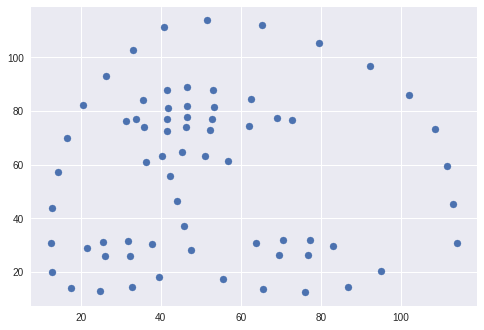

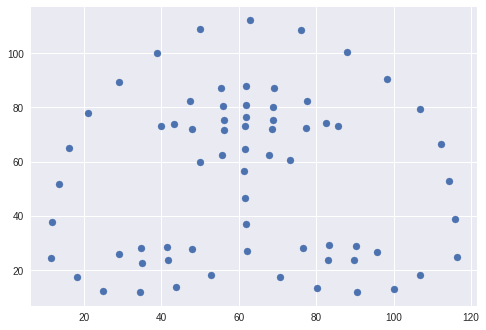

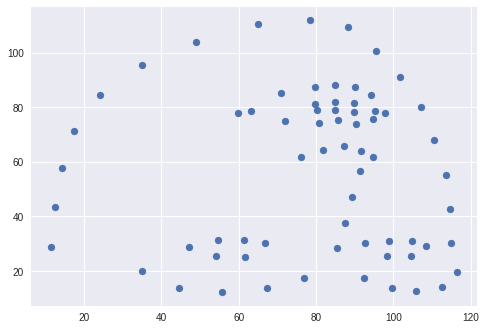

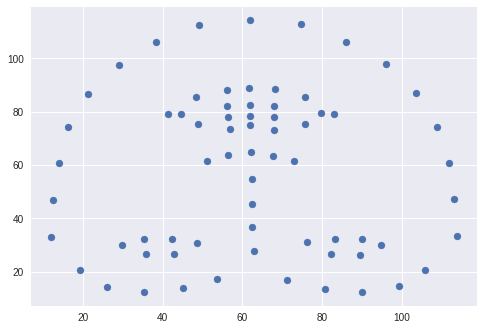

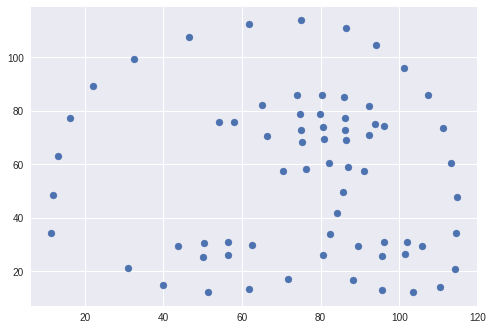

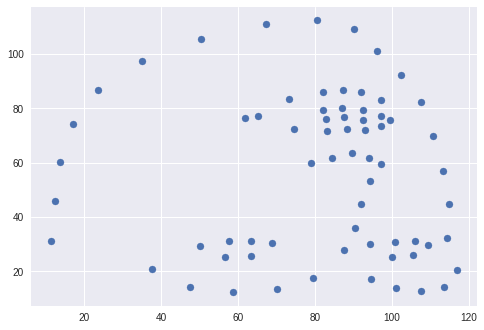

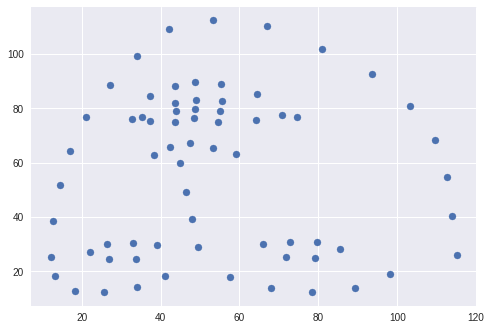

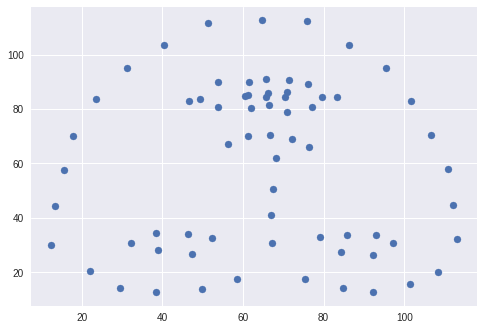

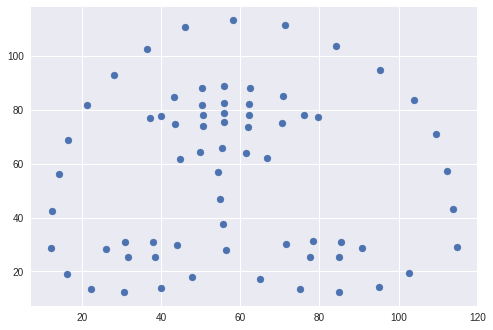

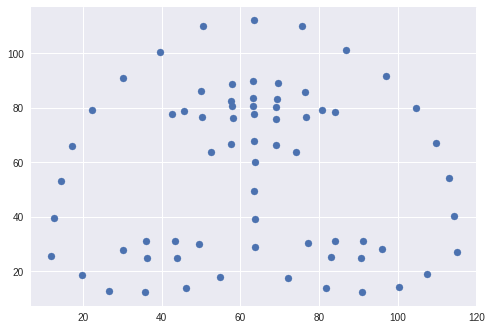

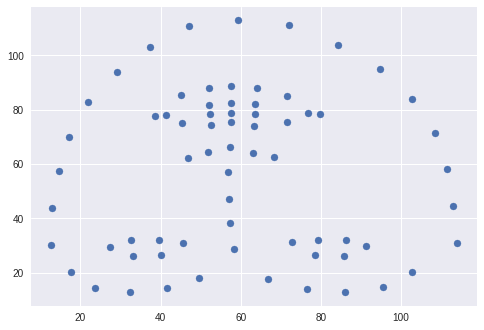

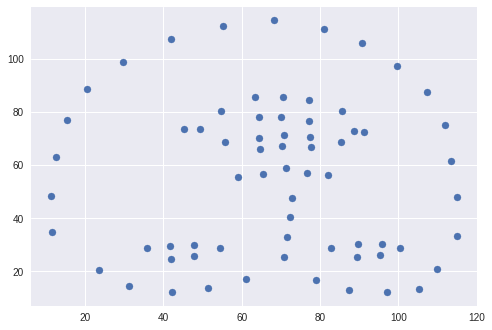

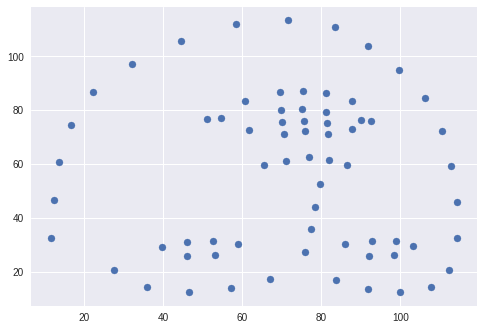

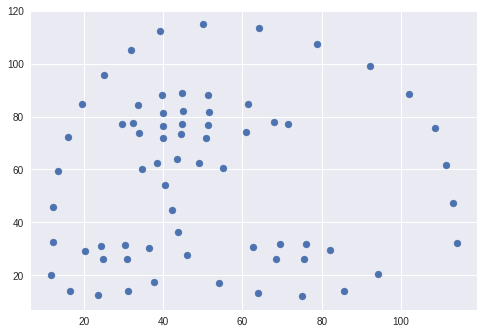

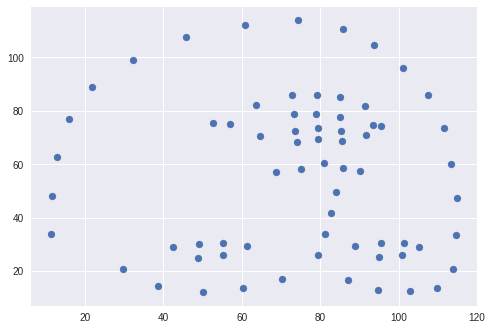

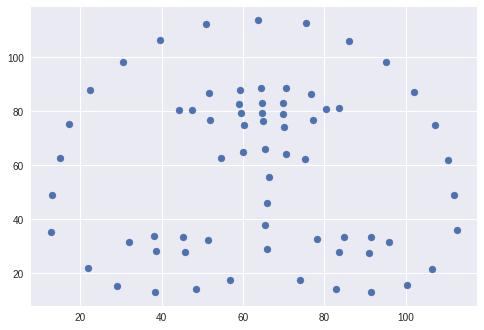

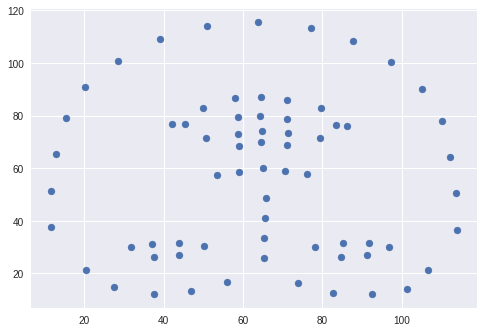

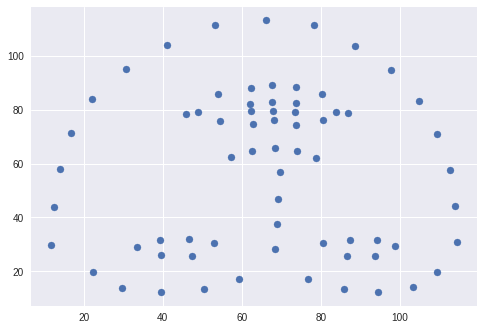

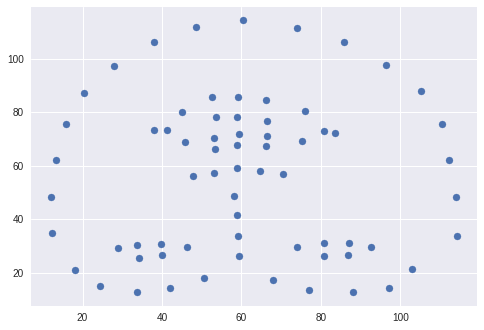

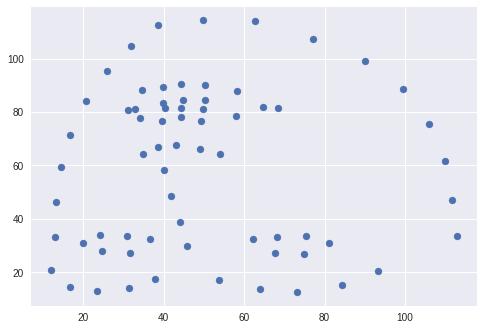

In [95]:
results_test = np.zeros((800, 68, 2))
with sess.as_default():
 
  test_batches = len(landmarks_test_norm) // batch_size
  
  for i in range(test_batches):
    start_ind = i * batch_size
    end_ind = (i + 1) * batch_size
    
    results_test[start_ind : end_ind] = lm_x4_2_reshape.eval(feed_dict = {X_lm : landmarks_test_norm[start_ind:end_ind]})
    
  print(results_test.shape)
  for j in range(150, 170):
    plt.scatter(results_test[j, :, 0]*128, results_test[j, :, 1]*128)
    plt.show()

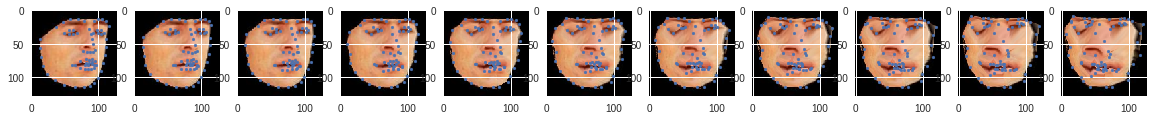

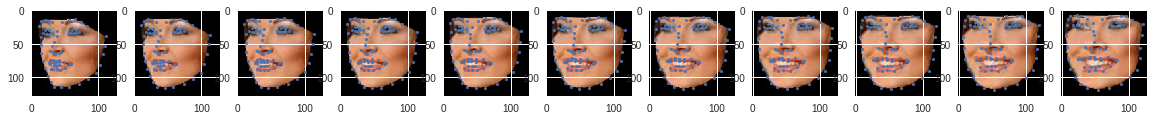

In [107]:
#Interpolation for landmarks
batch_size = 100
results = np.zeros((800, 10))
with sess.as_default():
  test_num_batches = len(landmarks_train_norm) // batch_size
  
  for i in range(test_num_batches):
    stind = i * batch_size
    endind = (i + 1) * batch_size
    results[stind:endind]=lm_x2_1_fc.eval(feed_dict={X_lm:landmarks_train_norm[stind:endind]})

  variance = np.zeros((10))

  for i in range(10):
    variance[i] = np.var(results[:,i])
    
  high_variance_dim = variance.argsort()[-2:][::-1]
  
  for i in range(len(high_variance_dim)):
    max_val_ind = np.argmax(results[:, high_variance_dim[i]])
    min_val_ind = np.argmin(results[:, high_variance_dim[i]])
    max_val = results[max_val_ind, high_variance_dim[i]]
    min_val = results[min_val_ind, high_variance_dim[i]]
    
    img = cv2.imread(folder + "/" + app_filenames[min_val_ind])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    step_size = (max_val - min_val) / float(10)
    
    interpol_d = np.zeros((11, 10))
    for j in range(11):
      interpol_d[j] = results[min_val_ind]
      interpol_d[j, high_variance_dim[i]] += j * step_size
      
    interpol_landmark = lm_x4_2_reshape.eval(feed_dict={lm_x2_1_fc:interpol_d})
      
    f, a = plt.subplots(1, 11, figsize=(20, 10), squeeze = False)
    for j in range(11):
        a[0][j].imshow(mywarper.warp(img, landmarks_train[min_val_ind], interpol_landmark[j] * 128))
        a[0][j].scatter(interpol_landmark[j,:,0] * 128, interpol_landmark[j,:, 1] * 128, s = 8)

In [0]:
X = tf.placeholder(tf.float32, [None, 128, 128, 3])

In [109]:
with tf.name_scope("Encoder"):
  
  x1_1_conv = tf.layers.conv2d(X, filters = 16, kernel_size = 5, strides = 2, padding='VALID')
  x1_2_relu = tf.nn.leaky_relu(x1_1_conv)
  print("w1")
  print(x1_2_relu.shape)

  x2_1_conv = tf.layers.conv2d(x1_2_relu, filters = 32, kernel_size = 3, strides = 2, padding='VALID')
  x2_2_relu = tf.nn.leaky_relu(x2_1_conv)
  print("w2")
  print(x2_2_relu.shape)

  x3_1_conv = tf.layers.conv2d(x2_2_relu, filters = 64, kernel_size = 3, strides = 2, padding='VALID')
  x3_2_relu = tf.nn.leaky_relu(x3_1_conv)
  print("w3")
  print(x3_2_relu.shape)

  x4_1_conv = tf.layers.conv2d(x3_2_relu, filters = 128, kernel_size = 3, strides = 2, padding='VALID')
  x4_2_relu = tf.nn.leaky_relu(x4_1_conv)
  print("w4")
  print(tf.contrib.layers.flatten(x4_2_relu).shape)
  
  x5_1_fc = tf.contrib.layers.fully_connected(tf.contrib.layers.flatten(x4_2_relu), 50, activation_fn = tf.nn.leaky_relu)
  print("w5")
  print(x5_1_fc.shape)

  x5_2_expand = tf.expand_dims(x5_1_fc, axis=1)
  x5_2_expand = tf.expand_dims(x5_2_expand, axis=1)

  print(x5_2_expand.shape)

w1
(?, 62, 62, 16)
w2
(?, 30, 30, 32)
w3
(?, 14, 14, 64)
w4
(?, 4608)
w5
(?, 50)
(?, 1, 1, 50)


In [110]:
with tf.name_scope("Decoder"):
  x6_1_deconv = tf.layers.conv2d_transpose(x5_2_expand, filters = 128, kernel_size = 6, strides = 1, padding='VALID')
  x6_2_relu = tf.nn.leaky_relu(x6_1_deconv)
  print(x6_2_relu.shape)

  x7_1_deconv = tf.layers.conv2d_transpose(x6_2_relu,filters = 64, kernel_size = 4, strides = 2, padding='VALID')
  x7_2_relu = tf.nn.leaky_relu(x7_1_deconv)
  print(x7_2_relu.shape)

  x8_1_deconv = tf.layers.conv2d_transpose(x7_2_relu, filters = 32, kernel_size = 4, strides = 2, padding='VALID')
  x8_2_relu = tf.nn.leaky_relu(x8_1_deconv)
  print(x8_2_relu.shape)

  x9_1_deconv = tf.layers.conv2d_transpose(x8_2_relu, filters = 16, kernel_size = 4, strides = 2, padding='VALID')
  x9_2_relu = tf.nn.leaky_relu(x9_1_deconv)
  print(x9_2_relu.shape)

  x10_1_deconv = tf.layers.conv2d_transpose(x9_2_relu, filters = 3, kernel_size = 6, strides = 2, padding='VALID')
  x10_2_sig = tf.nn.sigmoid(x10_1_deconv)
  print(x10_2_sig.shape)

(?, 6, 6, 128)
(?, 14, 14, 64)
(?, 30, 30, 32)
(?, 62, 62, 16)
(?, 128, 128, 3)


In [111]:
learning_rate = 7e-4
loss = tf.reduce_mean(tf.square(x10_2_sig-X))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_obj = optimizer.minimize(loss)

init = tf.global_variables_initializer()

epochs = 300
batch_size = 100

sess = tf.Session() 
sess.run(init)

for epoch in range(epochs):
  print("Epoch " + str(epoch))
  
  batches = 800 // batch_size
  print(batches)
  
  for i in range(batches):
    print("Iter: " + str(i))
    start_ind = i * batch_size
    end_ind = (i + 1) * batch_size

    sess.run(train_obj, feed_dict = {X : train_warped_img[start_ind : end_ind]})
    
    with sess.as_default():
      train_loss=loss.eval(feed_dict={X : train_warped_img[start_ind:end_ind]})
      print(i, end = ' ')
      print(train_loss)

Epoch 0
8
Iter: 0
0 0.14760838
Iter: 1
1 0.14634143
Iter: 2
2 0.146444
Iter: 3
3 0.14781189
Iter: 4
4 0.1478411
Iter: 5
5 0.14641611
Iter: 6
6 0.14860624
Iter: 7
7 0.14672221
Epoch 1
8
Iter: 0
0 0.14619035
Iter: 1
1 0.14462593
Iter: 2
2 0.14414789
Iter: 3
3 0.14485198
Iter: 4
4 0.14338575
Iter: 5
5 0.13857707
Iter: 6
6 0.13410413
Iter: 7
7 0.12091966
Epoch 2
8
Iter: 0
0 0.10495368
Iter: 1
1 0.088267475
Iter: 2
2 0.07526501
Iter: 3
3 0.07322667
Iter: 4
4 0.06933069
Iter: 5
5 0.062684864
Iter: 6
6 0.054334037
Iter: 7
7 0.046835996
Epoch 3
8
Iter: 0
0 0.04078463
Iter: 1
1 0.039322328
Iter: 2
2 0.038746398
Iter: 3
3 0.038285427
Iter: 4
4 0.036268916
Iter: 5
5 0.032819215
Iter: 6
6 0.03212826
Iter: 7
7 0.029111411
Epoch 4
8
Iter: 0
0 0.025979321
Iter: 1
1 0.02498205
Iter: 2
2 0.026404884
Iter: 3
3 0.025980858
Iter: 4
4 0.024192316
Iter: 5
5 0.02325118
Iter: 6
6 0.023881905
Iter: 7
7 0.022363165
Epoch 5
8
Iter: 0
0 0.01931077
Iter: 1
1 0.018829722
Iter: 2
2 0.020373097
Iter: 3
3 0.020700783


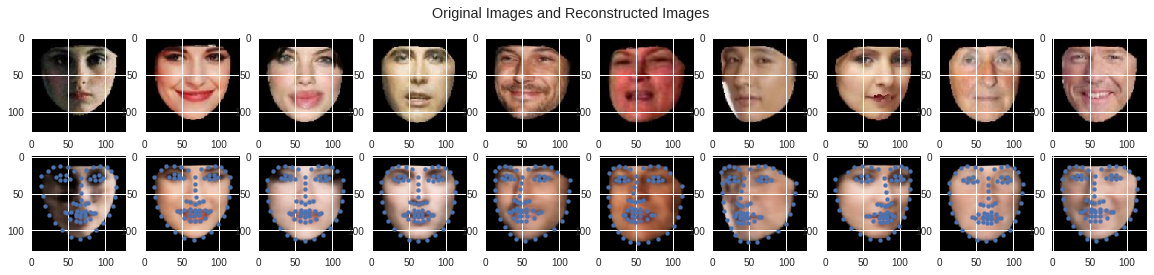

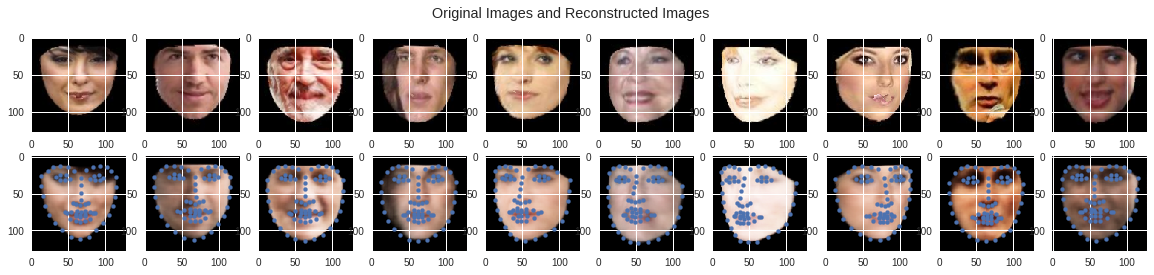

In [112]:
with sess.as_default():
  test_num_batches = len(test_warped_img) // batch_size
  for i in range(test_num_batches):
    stind = i * batch_size
    endind = (i + 1) * batch_size
    results = x10_2_sig.eval(feed_dict = {X : test_warped_img[stind:endind]})
    
    num_test_images = endind - stind + 1
    f,a=plt.subplots(2,10,figsize=(20,4), squeeze = False)
    for j in range(10):
      
        a[0][j].imshow(mywarper.warp(test_warped_img[stind + j], landmark_mean, landmarks_test[j]))
        a[1][j].imshow(mywarper.warp(results[j], landmark_mean, results_test[j] * 128))
        a[1][j].scatter(results_test[j, :, 0] * 128, results_test[j, :, 1] * 128, s = 16)
    f.suptitle('Original Images and Reconstructed Images')
  

In [0]:
#####################################################

In [0]:
####################Interpolation###############################

In [0]:
####################Appearance interpolation###############################

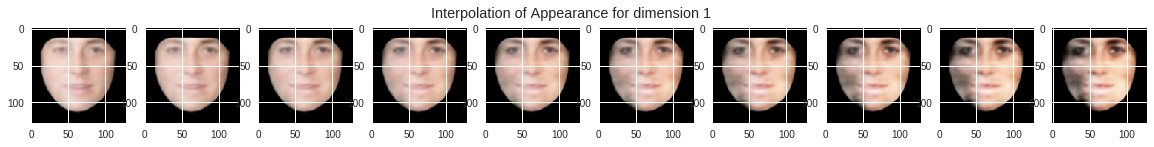

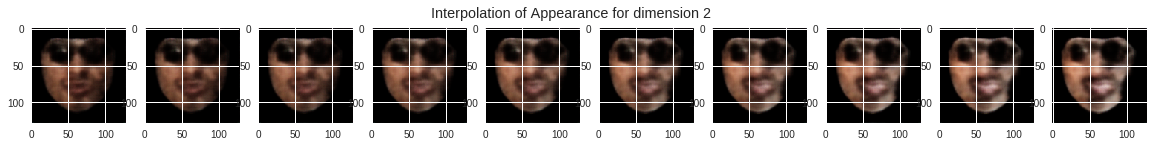

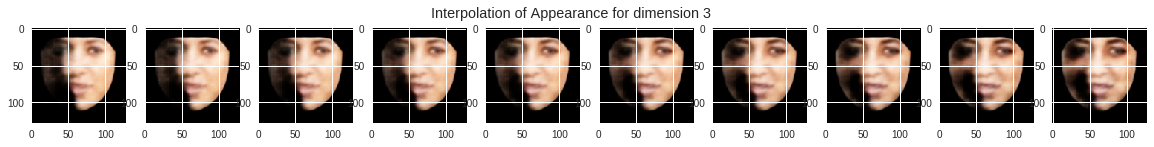

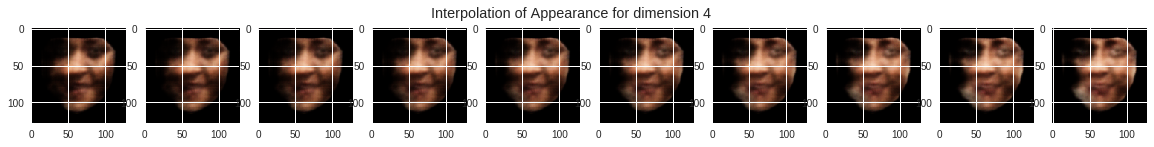

In [119]:
app_results = np.zeros((800, 1, 1, 50))
with sess.as_default():
  test_num_batches = len(train_warped_img) // batch_size
  for i in range(test_num_batches):
    stind = i * batch_size
    endind = (i + 1) * batch_size
    app_results[stind:endind]= sess.run(x5_2_expand,feed_dict={X:train_warped_img[stind:endind]})

  app_variance = np.zeros((50))

  for i in range(50):
    app_variance[i] = np.var(app_results[:, :, :, i])
    
  app_high_variance_dim = app_variance.argsort()[-4:][::-1]
  
  for i in range(len(app_high_variance_dim)):
    app_max_val_ind = np.argmax(app_results[:, :, :, app_high_variance_dim[i]])
    app_min_val_ind = np.argmin(app_results[:, :, :, app_high_variance_dim[i]])
    app_max_val = app_results[app_max_val_ind, :, :, app_high_variance_dim[i]]
    app_min_val = app_results[app_min_val_ind, :, :, app_high_variance_dim[i]]
    
    app_step_size = (app_max_val - app_min_val) / float(10)

    app_interpol_d = np.zeros((10, 1, 1, 50))
    for j in range(10):
      app_interpol_d[j] = app_results[app_min_val_ind]
      app_interpol_d[j, :, :, app_high_variance_dim[i]] += j * app_step_size    

    app_interpol = x10_2_sig.eval(feed_dict={x5_2_expand:app_interpol_d})

    f,a=plt.subplots(1,10,figsize=(20,2), squeeze = False)
    for j in range(10):
        a[0, j].imshow(app_interpol[j])
    f.suptitle('Interpolation of Appearance for dimension ' + str(i + 1))